In [1]:
import pandas as pd
import os
import shutil
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import soundfile
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Lambda, Reshape

# Preparing data

In [3]:
# Clearing metadata
metadata_path = 'archive\\metadata.csv'
md = pd.read_csv(metadata_path)
metadata = md[['id', 'name','filename']]

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5422 non-null   int64 
 1   name      5422 non-null   object
 2   filename  5422 non-null   object
dtypes: int64(1), object(2)
memory usage: 127.2+ KB


In [ ]:
# Crosschecking files with csv - no need to run this cell
# A lot of files are unlabeled - its important too making sets only with labeled data
csv_filenames = metadata['filename'].tolist()

for filename in os.listdir('archive\\wavfiles'):
    if filename not in csv_filenames:
        print(f"File {filename} is not in csv.")

In [5]:
# Checking bird names
names = metadata["name"].unique()
names

array(["Bewick's Wren", 'Northern Mockingbird', 'American Robin',
       'Song Sparrow', 'Northern Cardinal'], dtype=object)

In [6]:
metadata["name"].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

In [21]:
# Moving files to according folders
for index, row in metadata.iterrows():
    if row['name'] == "Song Sparrow":
        shutil.move(os.path.join('archive\\wavfiles', row['filename']), os.path.join('archive\\sparrow', row['filename']))
    else:
        shutil.move(os.path.join('archive\\wavfiles', row['filename']), os.path.join('archive\\other', row['filename']))

In [10]:
# Converting to 16-bit and moving to data folder
for file in os.listdir('archive\\sparrow'):
    data, samplerate = soundfile.read(os.path.join('archive\\sparrow', file))
    soundfile.write(os.path.join('data\\sparrow', file), data, samplerate, subtype='PCM_16')

for file in os.listdir('archive\\other'):
    data, samplerate = soundfile.read(os.path.join('archive\\other', file))
    soundfile.write(os.path.join('data\\other', file), data, samplerate, subtype='PCM_16')

In [2]:
# Loading files 16khz, mono
def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True) 
    return wav

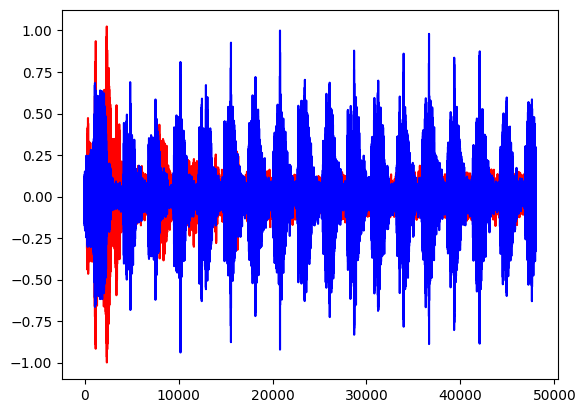

In [3]:
# Testing decode function
sparrow_wav = load_wav_16k_mono('data\\sparrow\\62782-7.wav')
other_wav   = load_wav_16k_mono('data\\other\\11846-6.wav')
plt.plot(sparrow_wav,'r')
plt.plot(other_wav, 'b')
plt.show()

# Creating dataset

In [4]:
# Creating labeled dataset
sparrow_path = os.path.join('data', 'sparrow')
other_path = os.path.join('data', 'other')

sparrow = tf.data.Dataset.list_files(sparrow_path+'\*.wav')
other = tf.data.Dataset.list_files(other_path+'\*.wav')

sparrow_zip = tf.data.Dataset.zip((sparrow, tf.data.Dataset.from_tensor_slices(tf.ones(len(sparrow)))))
other_zip = tf.data.Dataset.zip((other, tf.data.Dataset.from_tensor_slices(tf.zeros(len(other)))))
data = sparrow_zip.concatenate(other_zip)

# Exploring data

In [10]:
lengths = []
for file in os.listdir(os.path.join('data', 'sparrow')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'sparrow', file))
    lengths.append(len(tensor_wave))

In [11]:
# All clips are the same length
print(f'Mean: {tf.math.reduce_mean(lengths)}')
print(f'Min: {tf.math.reduce_min(lengths)}')
print(f'Max: {tf.math.reduce_max(lengths)}')

Mean: 48000
Min: 48000
Max: 48000


# Converting to spectogram

In [12]:
def spectogram_old(file_path, label): # This function doesn't work with tensors
    wav = load_wav_16k_mono(file_path)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [5]:
def spectogram(file_path, label): # Code written by chat-gpt, may be broken
    def load_and_transform(file_path):
        wav = librosa.load(file_path.numpy(), sr=16000, mono=True)[0]
        spectrogram = np.abs(librosa.stft(wav, n_fft=320, hop_length=32))

        spectrogram = np.rot90(spectrogram, k=-1)

        spectrogram = np.fliplr(spectrogram)
        return np.expand_dims(spectrogram, axis=-1)
    
    [spectrogram] = tf.py_function(load_and_transform, [file_path], [tf.float32])
    spectrogram.set_shape((None, None, 1))  
    return spectrogram, label

In [14]:
temp = sparrow_zip.shuffle(buffer_size=10000).as_numpy_iterator().next() # Temporary copy for comparing spectogram functions

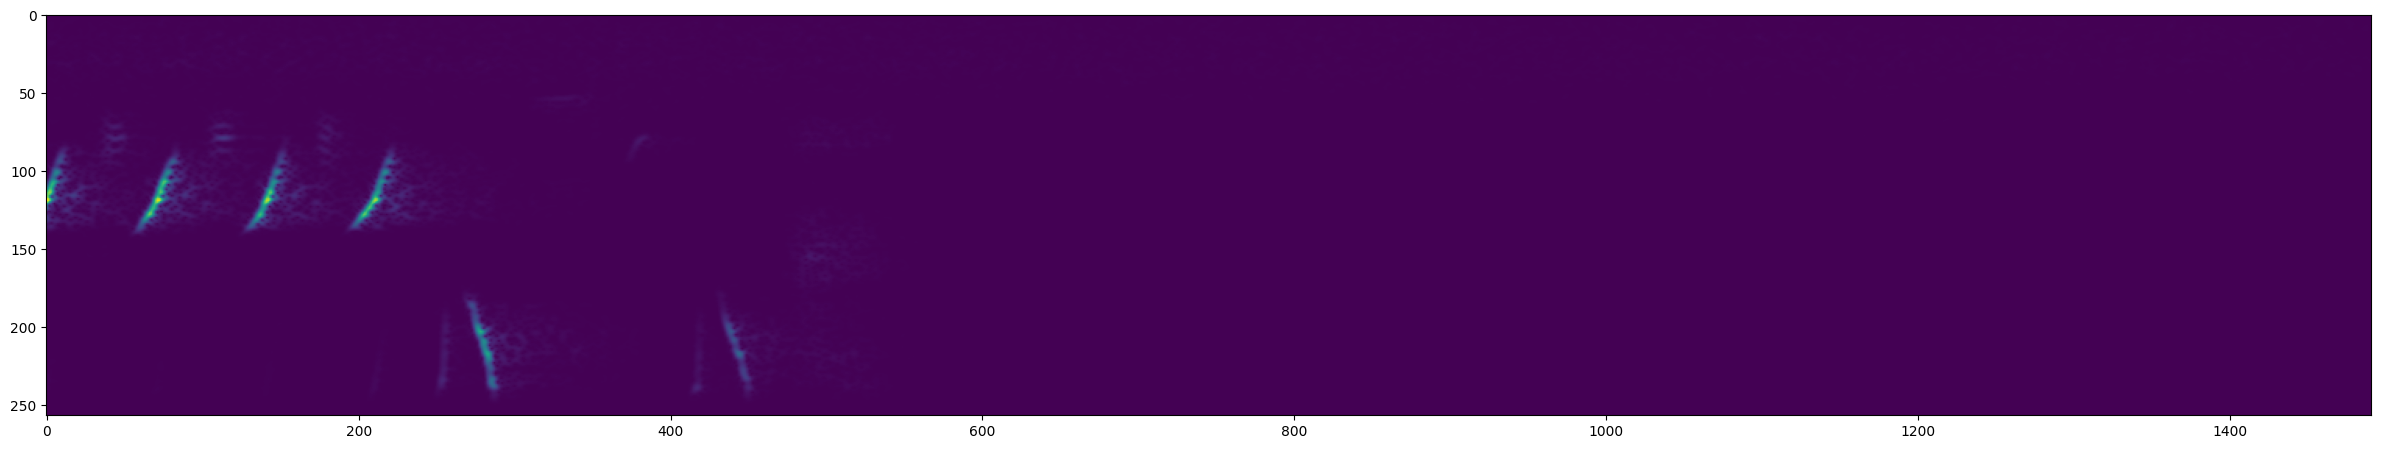

In [15]:
filepath, label = temp
spectrogram, label = spectogram_old(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

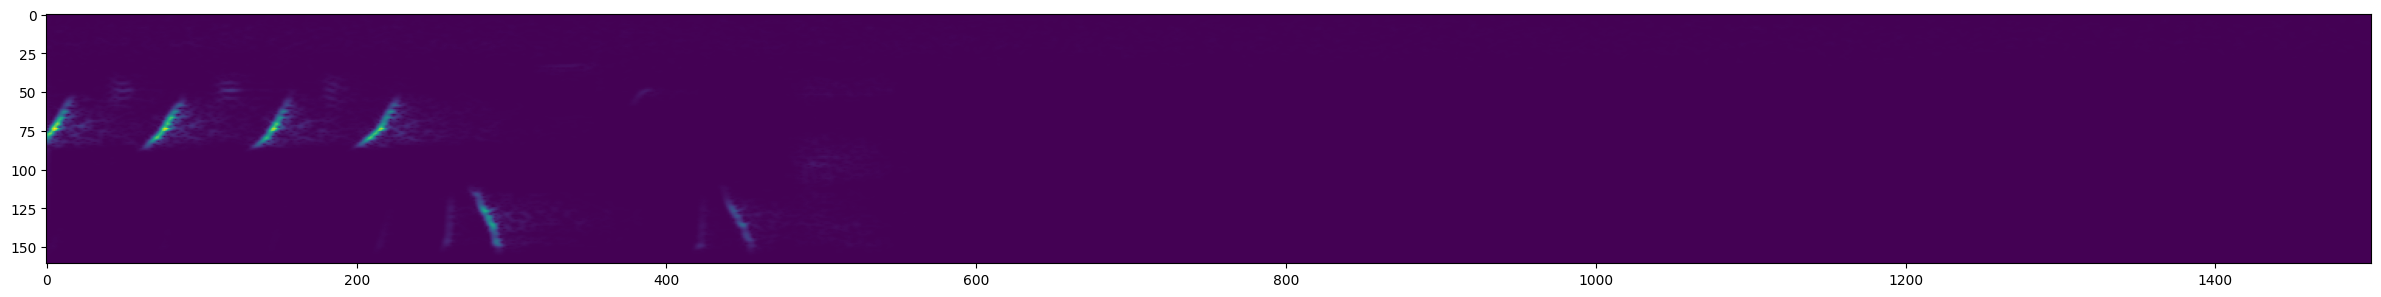

In [16]:
# Close enough
filepath, label = temp
spectrogram, label = spectogram(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Creating data subsets

In [6]:
# Mapping and batching data
data = data.map(spectogram)
data = data.cache()
data = data.shuffle(buffer_size=6000)
data = data.batch(16)
data = data.prefetch(8)

In [18]:
len(data)

339

In [19]:
# Calculating sizes
print(f'Train: {339 * 0.7}') #237
print(f'Val: {339 * 0.2}')   #68
print(f'Test: {339 * 0.1}')  #34

Train: 237.29999999999998
Val: 67.8
Test: 33.9


In [7]:
# Dividing data to subsets
train = data.take(237)
test = data.skip(237).take(68)
val = data.skip(237+68).take(34)

In [8]:
samples, labels = val.as_numpy_iterator().next()

In [9]:
# Checking input shape
samples.shape

(16, 1501, 161, 1)

# Building and training model

In [10]:
# Building model - reshape instead of flatten is somehow needed
model = Sequential()
model.add(Input(shape=(1501, 161, 1)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Reshape((-1,)))  
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1501, 161, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 375, 40, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 375, 40, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 93, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       952,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,929 (3.64 MB)

 Trainable params: 954,929 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.4660 - precision: 0.6212 - recall: 0.5613 - val_loss: 0.1908 - val_precision: 0.7742 - val_recall: 0.8571
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.2407 - precision: 0.7989 - recall: 0.7754 - val_loss: 0.1847 - val_precision: 0.9043 - val_recall: 0.8000
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - loss: 0.1817 - precision: 0.8559 - recall: 0.8630 - val_loss: 0.1371 - val_precision: 0.7862 - val_recall: 0.9843
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.1136 - precision: 0.8979 - recall: 0.9173 - val_loss: 0.0735 - val_precision: 0.9457 - val_recall: 0.9606
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0757 - precision: 0.9401 - recall: 0.9371 - val_loss: 0.0596 - val_precision: 1.0000 - val_recall: 0.9259
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.0604 - precision: 0.9521 - recall: 0.9611 - val_loss: 0.0266 - val_precision: 0.9741 -

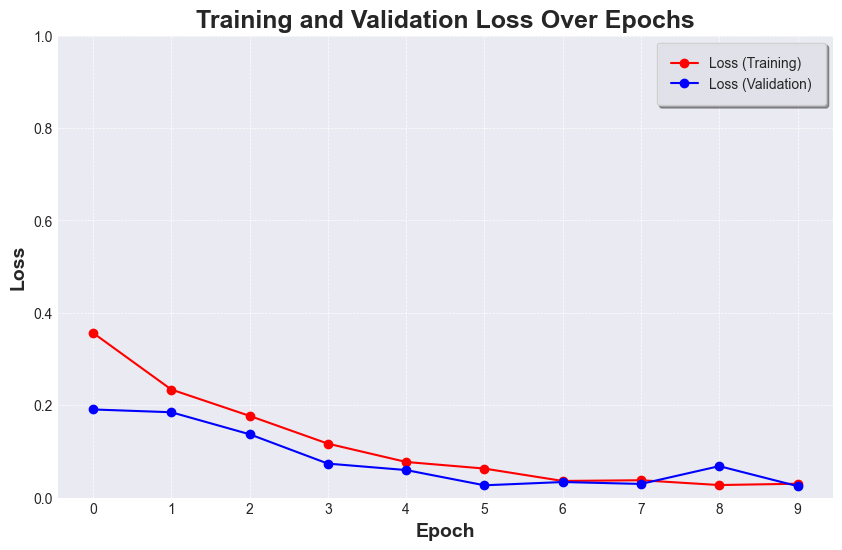

In [15]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hist.history['loss'], color='red', marker='o', label='Loss (Training)')
ax.plot(hist.history['val_loss'], color='blue', marker='o', label='Loss (Validation)')

ax.set_title('Training and Validation Loss Over Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, fontweight='bold')

ax.set_ylim([0, 1])

ax.set_xticks(np.arange(start=0, stop=len(hist.history['loss']), step=1))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

legend = ax.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1)

plt.show()

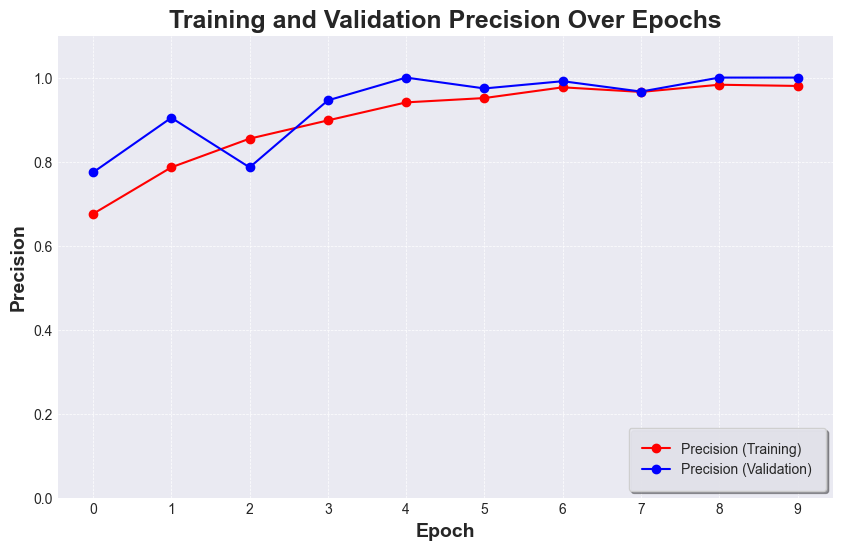

In [19]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hist.history['precision'], color='red', marker='o', label='Precision (Training)')
ax.plot(hist.history['val_precision'], color='blue', marker='o', label='Precision (Validation)')

ax.set_title('Training and Validation Precision Over Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')

ax.set_ylim([0, 1.1])

ax.set_xticks(np.arange(start=0, stop=len(hist.history['loss']), step=1))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

legend = ax.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1, loc='lower right')

plt.show()

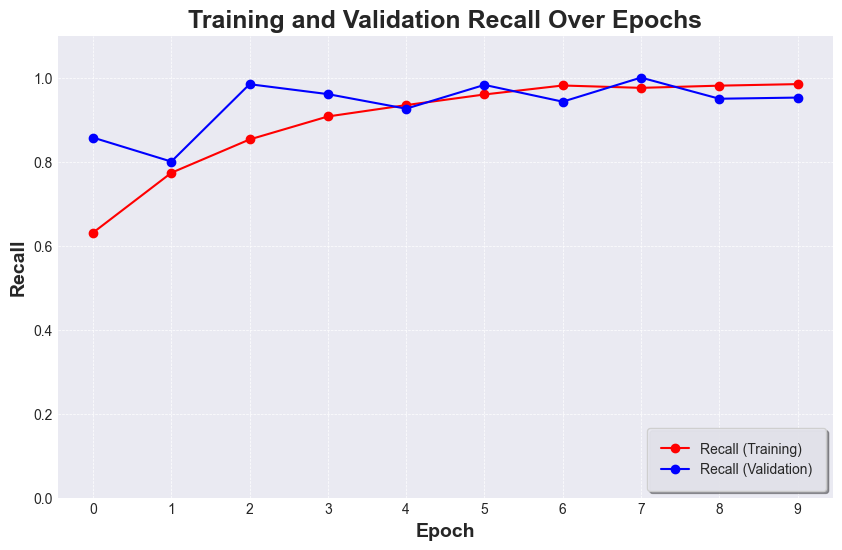

In [21]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hist.history['recall'], color='red', marker='o', label='Recall (Training)')
ax.plot(hist.history['val_recall'], color='blue', marker='o', label='Recall (Validation)')

ax.set_title('Training and Validation Recall Over Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Recall', fontsize=14, fontweight='bold')

ax.set_ylim([0, 1.1])

ax.set_xticks(np.arange(start=0, stop=len(hist.history['loss']), step=1))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

legend = ax.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1, loc='lower right')

plt.show()

# Testing model 

In [177]:
X_test, y_test = test.as_numpy_iterator().next()

In [178]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [179]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [180]:
yhat

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [181]:
y_test

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [32]:
false_positives = 0
true_positives = 0
false_negatives = 0
true_negatives = 0
for test_case in test.as_numpy_iterator():
    X = test_case[0]
    y = test_case[1]
    y_hat = model.predict(X)
    y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

    for i in range(len(y_hat)):
        if y[i] == 0:
            if y_hat[i] == 0: true_negatives+=1
            else: false_positives+=1
        if y[i] == 1:
            if y_hat[i] == 0: false_negatives+=1
            else: true_positives+=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [33]:
print(f"False positives: {false_positives}")
print(f"True positives: {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"True negatives: {true_negatives}")

False positives: 2
True positives: 257
False negatives: 1
True negatives: 828


# Saving the model

In [36]:
from keras.models import load_model

model.save('sparrow_detect.h5')
